In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import string
import re  
import heapq

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
talents = pd.read_csv('potential-talents.csv')

In [ ]:
talents.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [ ]:
talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [ ]:
talents.job_title.value_counts()

Aspiring Human Resources Professional                                                                                    7
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Native English Teacher at EPIK (English Program in Korea)                                                                5
SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR              4
Human Resources 

In [ ]:
talents.location.value_counts()

Kanada                                 12
Houston, Texas Area                     8
Raleigh-Durham, North Carolina Area     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
Greater Philadelphia Area               5
San Francisco Bay Area                  5
Atlanta, Georgia                        4
İzmir, Türkiye                          4
Lake Forest, California                 4
Austin, Texas Area                      2
Chicago, Illinois                       2
Amerika Birleşik Devletleri             2
Greater Atlanta Area                    2
Los Angeles, California                 1
Bridgewater, Massachusetts              1
Chattanooga, Tennessee Area             1
Milpitas, California                    1
Katy, Texas                             1
Baton Rouge, Louisiana Area             1
Myrtle Beach, South Carolina Area       1
Dallas/Fort Worth Area                  1
Jackson, Mississippi Area         

In [ ]:
 talents.connection = talents.connection.replace({'500+':500,'500+ ':500})


In [ ]:
talents.connection.value_counts()

500    44
61      7
85      7
44      6
1       5
2       4
4       2
390     2
57      2
7       2
40      1
155     1
19      1
103     1
174     1
49      1
39      1
71      1
268     1
409     1
5       1
212     1
455     1
349     1
48      1
82      1
50      1
52      1
9       1
415     1
64      1
18      1
16      1
Name: connection, dtype: int64

In [ ]:
talents.connection = talents.connection.astype('int')

In [ ]:
talents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


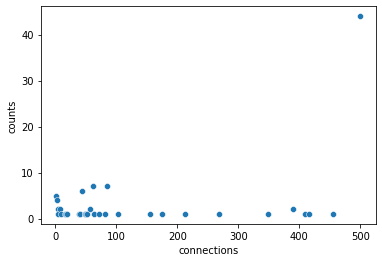

In [ ]:
#plot connection
connection = talents.connection.value_counts()
connection = connection.sort_index()
ax = sns.scatterplot(data=connection)
ax.set(xlabel='connections', ylabel='counts');

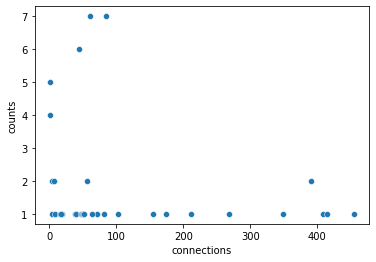

In [ ]:
#plot connection under 500
connection_under500 = talents[talents.connection < 500].connection.value_counts()
connection_under100 = connection.sort_index()
ax = sns.scatterplot(data=connection_under500)
ax.set(xlabel='connections', ylabel='counts');

In [ ]:
#convert connection from series to dataframe with index as an column
connection = connection.to_frame().reset_index()
connection = connection.rename(columns={'index':'connections','connection':'count'})

In [ ]:
#bin counts of connections
connection['binned']=pd.cut(x=connection['connections'], bins=[0,99,199,299,399,499,599],
                            labels = ['0-99', '100-199','200-299','300-399','400-499','500+'])
connection_bins = connection.groupby('binned')['count'].sum().reset_index()
connection_bins

,binned,count
0,0-99,49
1,100-199,3
2,200-299,2
3,300-399,3
4,400-499,3
5,500+,44


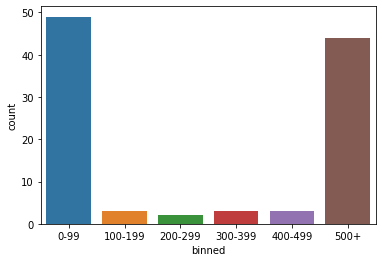

In [ ]:
#plot bins counts
sns.barplot(x='binned',y='count',data=connection_bins);

In [ ]:
#let's focus on just the job title for now
df = talents.job_title
df

0      2019 C.T. Bauer College of Business Graduate (...
1      Native English Teacher at EPIK (English Progra...
2                  Aspiring Human Resources Professional
3                 People Development Coordinator at Ryan
4        Advisory Board Member at Celal Bayar University
                             ...                        
99     Aspiring Human Resources Manager | Graduating ...
100                Human Resources Generalist at Loparex
101     Business Intelligence and Analytics at Travelers
102                       Always set them up for Success
103     Director Of Administration at Excellence Logging
Name: job_title, Length: 104, dtype: object

In [ ]:
# we are atttempting bag of words model
# Step 1: Tokenize the Sentences

# take all job title and create corpus
job_title = ''
for title in talents.job_title: 
    job_title += ' '
    job_title += title
corpus = nltk.sent_tokenize(job_title)

In [ ]:
#clean up the text by removing space and punctuation
for i in range(len(corpus )):
    corpus [i] = corpus [i].lower()
    corpus [i] = re.sub(r'\W',' ',corpus [i])
    corpus [i] = re.sub(r'\s+',' ',corpus [i])

In [ ]:
print(len(corpus))

16


In [ ]:
#print a sample from our corpus
print(corpus[8])

human resources generalist at scottmadden inc business management major and aspiring human resources manager aspiring human resources manager seeking internship in human resources 


In [ ]:
#Step 2: create a dictionary of each unique word and count their occurance
wordfreq = {}
for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
print(wordfreq)

{'2019': 7, 'c': 7, 't': 7, 'bauer': 7, 'college': 14, 'of': 11, 'business': 11, 'graduate': 7, 'magna': 7, 'cum': 7, 'laude': 7, 'and': 28, 'aspiring': 35, 'human': 63, 'resources': 63, 'professional': 20, 'native': 5, 'english': 10, 'teacher': 5, 'at': 46, 'epik': 5, 'program': 5, 'in': 10, 'korea': 5, 'people': 6, 'development': 6, 'coordinator': 10, 'ryan': 6, 'advisory': 4, 'board': 4, 'member': 4, 'celal': 4, 'bayar': 4, 'university': 12, 'specialist': 12, 'student': 16, 'humber': 7, 'generalist': 14, 'hr': 6, 'senior': 6, 'seeking': 15, 'hris': 4, 'positions': 4, 'chapman': 4, 'svp': 4, 'chro': 4, 'marketing': 4, 'communications': 4, 'csr': 4, 'officer': 4, 'engie': 4, 'houston': 4, 'the': 5, 'woodlands': 4, 'energy': 4, 'gphr': 4, 'sphr': 4, 'intercontinental': 4, 'buckhead': 4, 'atlanta': 4, 'management': 7, 'an': 5, 'internship': 3, 'opportunities': 4, 'experienced': 1, 'retail': 2, 'manager': 7, 'staffing': 2, 'recruiting': 1, 'luxottica': 1, 'director': 3, 'north': 2, 'amer

In [ ]:
#create a list contains 200 most frequently occurring words 
# along with their frequency of occurrence.
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

In [ ]:
#step 3: craete bag of word d model
#for each word in the most_freq dictionary
#if the word exists in the sentence, 
#a 1 will be added for the word, else 0 will be added.
sentence_vectors = []
for sentence in corpus:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

In [ ]:
#convert into matrix
sentence_vectors = np.asarray(sentence_vectors)
sentence_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
#find the most common 20 words
wordfreqdf = pd.DataFrame(columns = ['word','freq'])
for key, value in wordfreq.items():
    wordfreqdf.loc[len(wordfreqdf.index)] = [key, value] 
wordfreqdf.sort_values(by='freq', ascending=False, inplace=True)
wordfreqdf = wordfreqdf.reset_index()
wordfreqdf.drop(columns=['index'], inplace=True)
wordfreqdf = wordfreqdf.iloc[0:20, :]
wordfreqdf

,word,freq
0,resources,63
1,human,63
2,at,46
3,aspiring,35
4,and,28
5,professional,20
6,student,16
7,seeking,15
8,generalist,14
9,college,14


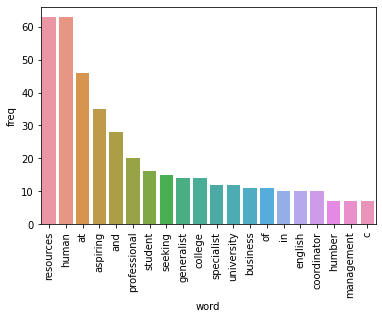

In [ ]:
#create a histogram of word frequency
ax = sns.barplot(data=wordfreqdf, x='word',y='freq')
ax.tick_params(axis='x', rotation=90)

In [ ]:
#try using tf.idf manually

job_title = ''
keyword_1 = 'Aspiring human resources' 
keyword_2 = 'seeking human resources'

for title in talents.job_title:  
    job_title += ' '
    job_title += title

job_title = job_title.lower()
keyword_1 = keyword_1.lower()
keyword_2 = keyword_2.lower()

job_title = re.sub(r'\W',' ',job_title)
keyword_1 = re.sub(r'\W',' ',keyword_1)
keyword_2 = re.sub(r'\W',' ',keyword_2)

jobtitle = re.sub(r'\s+',' ',job_title)
keyword_1 = re.sub(r'\s+',' ',keyword_1)
keyword_2 = re.sub(r'\W',' ',keyword_2)

bagOfWords = job_title.split(' ')
bagOfWords_key1 = keyword_1.split(' ')
bagOfWords_key2 = keyword_2.split(' ')

print(bagOfWords)
print(bagOfWords_key1)
print(bagOfWords_key2)

['', '2019', 'c', 't', '', 'bauer', 'college', 'of', 'business', 'graduate', '', 'magna', 'cum', 'laude', '', 'and', 'aspiring', 'human', 'resources', 'professional', 'native', 'english', 'teacher', 'at', 'epik', '', 'english', 'program', 'in', 'korea', '', 'aspiring', 'human', 'resources', 'professional', 'people', 'development', 'coordinator', 'at', 'ryan', 'advisory', 'board', 'member', 'at', 'celal', 'bayar', 'university', 'aspiring', 'human', 'resources', 'specialist', 'student', 'at', 'humber', 'college', 'and', 'aspiring', 'human', 'resources', 'generalist', 'hr', 'senior', 'specialist', 'student', 'at', 'humber', 'college', 'and', 'aspiring', 'human', 'resources', 'generalist', 'seeking', 'human', 'resources', 'hris', 'and', 'generalist', 'positions', 'student', 'at', 'chapman', 'university', 'svp', '', 'chro', '', 'marketing', '', '', 'communications', '', 'csr', 'officer', '', '', 'engie', '', '', 'houston', '', '', 'the', 'woodlands', '', '', 'energy', '', '', 'gphr', '', ''

In [ ]:
#remove duplicate words
uniqueWords = set(bagOfWords)
uniqueWords = set(bagOfWords).union(set(bagOfWords_key1)).union(set(bagOfWords_key2))
print(uniqueWords)

{'', 'national', 'laude', 'marketing', 'endemol', 'administration', 'groupe', 'travelers', 'center', 'native', 'helping', 'world', 'illinois', 'junior', 'always', 'people', 'hardware', 'opportunities', 'passionate', 'compensation', 'development', 'college', 'official', 'wellington', 'communications', 'professionals', 'community', 'america', 'assistant', 'and', 'programmer', 'create', 'hris', 'bachelor', 'is', 'entry', 'japan', 'loparex', 'payroll', 'major', 'guard', 'specialist', 'magna', 'beach', 'bauer', 'indiana', 'professional', 'st', 'program', 'information', 'paint', 'member', 'english', 'c', 'csr', 'benefits', 'set', 'biology', 'engie', 'styczynski', 'open', 'resources', 'westfield', 'work', 'leader', 'analytics', 's', 'customer', '2621', 'an', 'army', 'management', 'retail', 'advisory', 'north', 'organization', 'lead', 'epik', 'the', '2019', 'recruiter', 'positions', 'for', 'louis', 'graduate', 'retired', 'long', '709', 'board', 'environment', 'svp', 'buckhead', 'medical', 'pat

In [ ]:
#create a dictionary of words and their occurence
numOfWords = dict.fromkeys(uniqueWords, 0)
for word in bagOfWords:
    numOfWords[word] += 1

numOfWords_key1 = dict.fromkeys(uniqueWords, 0)
for word in bagOfWords_key1:
    numOfWords_key1[word] += 1

numOfWords_key2 = dict.fromkeys(uniqueWords, 0)
for word in bagOfWords_key1:
    numOfWords_key2[word] += 1

print(numOfWords)
print(numOfWords_key1)
print(numOfWords_key2)

{'': 148, 'national': 1, 'laude': 7, 'marketing': 4, 'endemol': 1, 'administration': 1, 'groupe': 1, 'travelers': 1, 'center': 1, 'native': 5, 'helping': 1, 'world': 1, 'illinois': 1, 'junior': 1, 'always': 1, 'people': 6, 'hardware': 1, 'opportunities': 4, 'passionate': 1, 'compensation': 1, 'development': 6, 'college': 14, 'official': 1, 'wellington': 1, 'communications': 4, 'professionals': 1, 'community': 1, 'america': 2, 'assistant': 1, 'and': 28, 'programmer': 1, 'create': 1, 'hris': 4, 'bachelor': 1, 'is': 1, 'entry': 1, 'japan': 1, 'loparex': 1, 'payroll': 1, 'major': 3, 'guard': 1, 'specialist': 12, 'magna': 7, 'beach': 1, 'bauer': 7, 'indiana': 1, 'professional': 20, 'st': 1, 'program': 5, 'information': 2, 'paint': 1, 'member': 4, 'english': 10, 'c': 7, 'csr': 4, 'benefits': 1, 'set': 1, 'biology': 1, 'engie': 4, 'styczynski': 1, 'open': 1, 'resources': 63, 'westfield': 1, 'work': 1, 'leader': 2, 'analytics': 1, 's': 1, 'customer': 1, '2621': 1, 'an': 5, 'army': 1, 'manageme

In [ ]:
#find term frequency
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict
tf = computeTF(numOfWords, bagOfWords)
tf_key1 = computeTF(numOfWords_key1, bagOfWords_key1)
tf_key2 = computeTF(numOfWords_key2, bagOfWords_key2)
print(tf)
print(tf_key1)
print(tf_key2)

{'': 0.15828877005347594, 'national': 0.0010695187165775401, 'laude': 0.0074866310160427805, 'marketing': 0.0042780748663101605, 'endemol': 0.0010695187165775401, 'administration': 0.0010695187165775401, 'groupe': 0.0010695187165775401, 'travelers': 0.0010695187165775401, 'center': 0.0010695187165775401, 'native': 0.0053475935828877, 'helping': 0.0010695187165775401, 'world': 0.0010695187165775401, 'illinois': 0.0010695187165775401, 'junior': 0.0010695187165775401, 'always': 0.0010695187165775401, 'people': 0.006417112299465241, 'hardware': 0.0010695187165775401, 'opportunities': 0.0042780748663101605, 'passionate': 0.0010695187165775401, 'compensation': 0.0010695187165775401, 'development': 0.006417112299465241, 'college': 0.014973262032085561, 'official': 0.0010695187165775401, 'wellington': 0.0010695187165775401, 'communications': 0.0042780748663101605, 'professionals': 0.0010695187165775401, 'community': 0.0010695187165775401, 'america': 0.0021390374331550803, 'assistant': 0.001069

In [ ]:
#find inverse data frequency
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

idfs = computeIDF([numOfWords])
#idfs_key1 = computeIDF([numOfWords_key1])
#idfs_key2 = computeIDF([numOfWords_key2])
print(idfs)
#print(idfs_key1)
#print(idfs_key2)

{'': 0.0, 'national': 0.0, 'laude': 0.0, 'marketing': 0.0, 'endemol': 0.0, 'administration': 0.0, 'groupe': 0.0, 'travelers': 0.0, 'center': 0.0, 'native': 0.0, 'helping': 0.0, 'world': 0.0, 'illinois': 0.0, 'junior': 0.0, 'always': 0.0, 'people': 0.0, 'hardware': 0.0, 'opportunities': 0.0, 'passionate': 0.0, 'compensation': 0.0, 'development': 0.0, 'college': 0.0, 'official': 0.0, 'wellington': 0.0, 'communications': 0.0, 'professionals': 0.0, 'community': 0.0, 'america': 0.0, 'assistant': 0.0, 'and': 0.0, 'programmer': 0.0, 'create': 0.0, 'hris': 0.0, 'bachelor': 0.0, 'is': 0.0, 'entry': 0.0, 'japan': 0.0, 'loparex': 0.0, 'payroll': 0.0, 'major': 0.0, 'guard': 0.0, 'specialist': 0.0, 'magna': 0.0, 'beach': 0.0, 'bauer': 0.0, 'indiana': 0.0, 'professional': 0.0, 'st': 0.0, 'program': 0.0, 'information': 0.0, 'paint': 0.0, 'member': 0.0, 'english': 0.0, 'c': 0.0, 'csr': 0.0, 'benefits': 0.0, 'set': 0.0, 'biology': 0.0, 'engie': 0.0, 'styczynski': 0.0, 'open': 0.0, 'resources': 0.0, 'we

In [ ]:
#find ifidfs
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf
tfidf = computeTFIDF(tf, idfs)
df = pd.DataFrame([tfidf])
print(df)

        national  laude  marketing  endemol  ...  within  atlanta  may   to  about
0  0.0       0.0    0.0        0.0      0.0  ...     0.0      0.0  0.0  0.0    0.0

[1 rows x 205 columns]


In [ ]:
#use sklearn for this instead

# preparing the words
job_title = list(talents.job_title)
keyword_1 = 'Aspiring human resources' 
keyword_2 = 'seeking human resources'
corpus = job_title
corpus.append(keyword_1)
corpus.append(keyword_2)
print(corpus)

['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', 'Native English Teacher at EPIK (English Program in Korea)', 'Aspiring Human Resources Professional', 'People Development Coordinator at Ryan', 'Advisory Board Member at Celal Bayar University', 'Aspiring Human Resources Specialist', 'Student at Humber College and Aspiring Human Resources Generalist', 'HR Senior Specialist', 'Student at Humber College and Aspiring Human Resources Generalist', 'Seeking Human Resources HRIS and Generalist Positions', 'Student at Chapman University', 'SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR', 'Human Resources Coordinator at InterContinental Buckhead Atlanta', '2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', '2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', 'Native En

In [ ]:
# sklearn for tf.idf
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df

,2019,2020,2621,408,709,about,administration,administrative,admissions,advisory,always,america,an,analyst,analytics,and,army,arts,aspiring,assistant,at,atlanta,bachelor,bauer,bayar,beach,benefits,beneteau,biology,board,brand,buckhead,business,care,celal,center,chapman,chro,college,communications,...,schwan,science,scottmadden,seeking,senior,service,set,shine,software,specialist,sphr,st,staffing,state,student,styczynski,success,svp,systems,talent,teacher,team,the,them,to,tobacco,travel,travelers,undergraduate,university,up,victoria,wellington,western,westfield,with,within,woodlands,work,world
0,0.31715,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.206582,0.0,0.0,0.181983,0.0,0.000000,0.0,0.0,0.31715,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.281364,0.0,0.000000,0.0,0.0,0.0,0.261669,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.150733,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.317215,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.519659,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.246890,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.415551,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.188599,0.0,0.0,0.00000,0.415551,0.0,0.0,0.0,0.0,0.415551,0.0,0.0,0.000000,0.0,0.415551,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.317833,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.515168,0.242147,0.0,0.0,0.000000,0.0,0.190789,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.329803,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.515168,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.417356,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.417356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.417356,0.0,0.0,0.0,0.000000,0.0,0.0,0.417356,0.0,0.0,0.0,0.000000,0.0,0.000000,0.417356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.00000,0.0,0.0,0.0,0.0,0.0